In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings 
warnings.filterwarnings('ignore')

from utils.data import create_sequences
from sklearn.preprocessing import StandardScaler
from utils.metrics import mar, far, f1_score

from models.lstm_ae import LSTM_AE
from utils.data import load_df, load_df_with_names
from utils.metrics import f1_score, far, mar



In [2]:
seed_value = 42

import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

In [29]:
features = ['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure',
       'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS']
# redundant_features = ['anomaly','changepoint','Accelerometer1RMS', 'Accelerometer2RMS', 'Current','Voltage','Pressure','Temperature', 'Thermocouple' ]
redundant_features = ['anomaly','changepoint','Accelerometer1RMS', 'Accelerometer2RMS', 'Current','Voltage','Thermocouple' ]

In [30]:
df_train = pd.read_csv("./data/valve1/6.csv", sep=";", parse_dates=True, index_col="datetime")
df_train.sort_index(inplace=True)

first_anomaly_idx = df_train.index.get_loc(df_train[df_train["anomaly"] == 1].index[0])
df_train = df_train.drop(redundant_features, axis=1)
train_size = int(first_anomaly_idx * 0.9)
train_size

518

In [31]:
x_train = df_train[:train_size]
x_train.head(3)

,Pressure,Temperature,Volume Flow RateRMS
datetime,,,
2020-03-09 12:14:36,0.382638,71.2129,32.0000
2020-03-09 12:14:37,0.710565,71.4284,32.0104
2020-03-09 12:14:38,0.054711,71.3468,32.0000


In [32]:
from utils.pipeline import Pipeline, Predictor
from tensorflow import keras

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
class Config:
    TIME_STEPS = 50
    epochs = 10
    batch_size = 10 
    Q = 0.99
    
conf = Config

ss = StandardScaler()
x_train = df_train[:train_size]

x_train = np.array(ss.fit_transform(x_train))
x_train = create_sequences(x_train, conf.TIME_STEPS)

model = LSTM_AE(optimizer=optimizer, loss='mae')
model.fit(x_train, conf.epochs, conf.batch_size, conf.TIME_STEPS)
health_r = pd.Series(np.sum(np.mean(np.abs(model.predict(x_train) - x_train), axis=1), axis=1))  
# UCL = health_r.quantile(conf.Q)

#####


Epoch 1/10
47/47 [==============================] - 10s 109ms/step - loss: 0.8253
Epoch 2/10
47/47 [==============================] - 5s 108ms/step - loss: 0.6581
Epoch 3/10
47/47 [==============================] - 5s 108ms/step - loss: 0.5638
Epoch 4/10
47/47 [==============================] - 5s 108ms/step - loss: 0.5436
Epoch 5/10
47/47 [==============================] - 5s 107ms/step - loss: 0.5296
Epoch 6/10
47/47 [==============================] - 5s 108ms/step - loss: 0.5233
Epoch 7/10
47/47 [==============================] - 5s 114ms/step - loss: 0.5183
Epoch 8/10
47/47 [==============================] - 5s 109ms/step - loss: 0.5147
Epoch 9/10
47/47 [==============================] - 5s 110ms/step - loss: 0.5117
Epoch 10/10
47/47 [==============================] - 5s 109ms/step - loss: 0.5097


In [33]:
list_of_df, _, file_names = load_df_with_names("./data/", "valve1")
s = sorted(zip(list_of_df, file_names), key = lambda x: x[0].index[0])
list_of_df, file_names = list(map(list, zip(*s)))

In [44]:
len(r), anomalous_data_indices

(1098,
 0         50
 1         51
 2         52
 3         53
 4         54
         ... 
 1093    1143
 1094    1144
 1095    1145
 1096    1146
 1097    1147
 Length: 1098, dtype: int64)

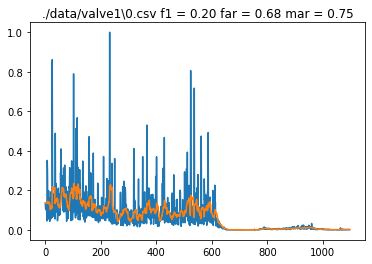

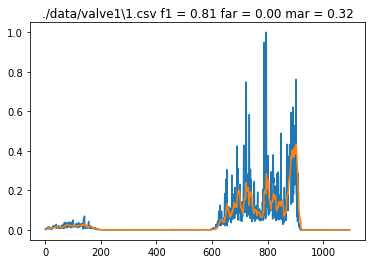

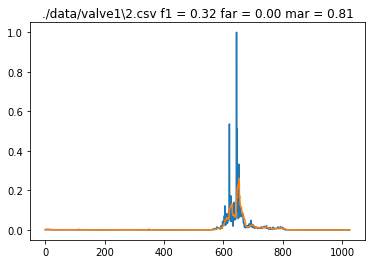

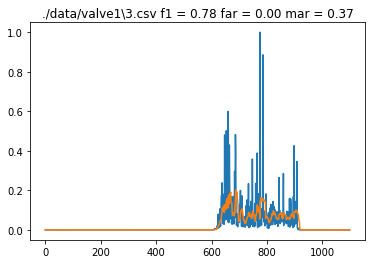

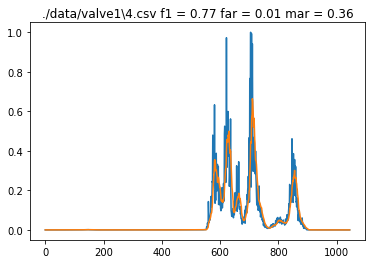

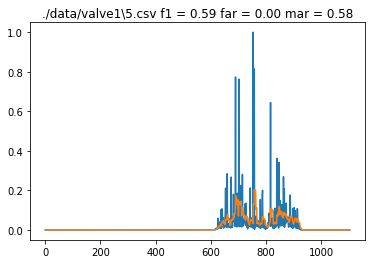

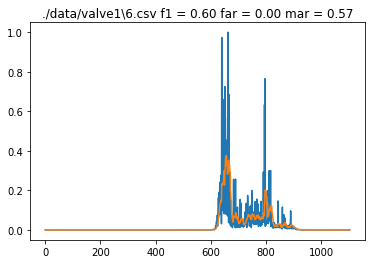

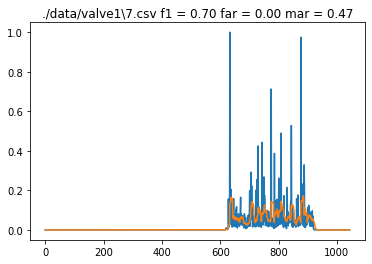

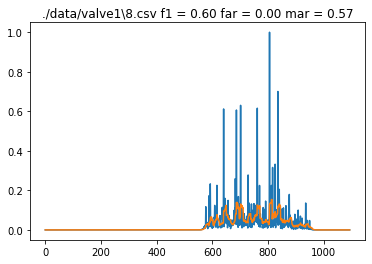

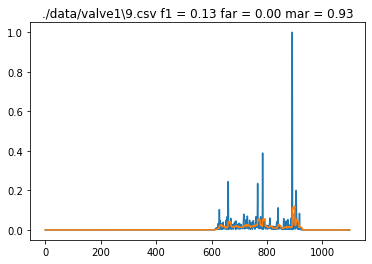

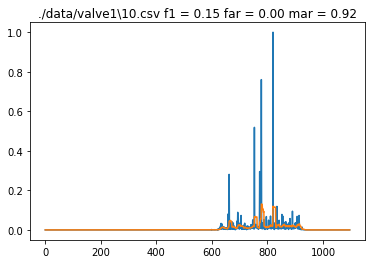

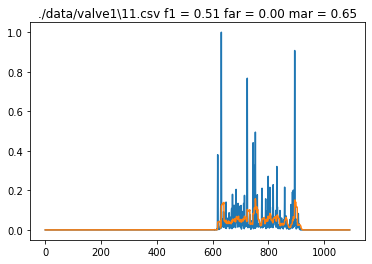

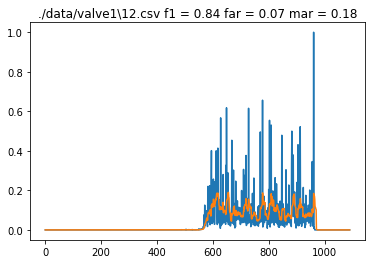

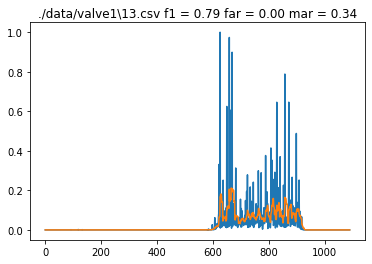

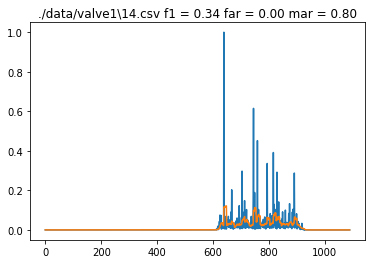

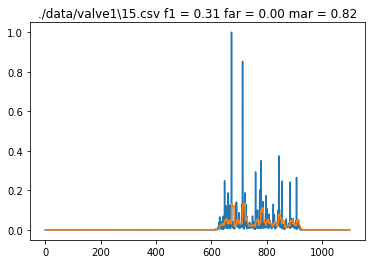

In [60]:
UCL = 0.05
predictions = []
for df, file_name in sorted(zip(list_of_df, file_names), key = lambda x: x[0].index[0]):
    y_test = df.anomaly
    df = df.drop(redundant_features, axis=1)
    
    x_test = np.array(ss.transform(df))
    x_test = create_sequences(x_test, conf.TIME_STEPS)
    r = pd.Series(np.sum(np.mean(np.abs(model.predict(x_test) - x_test), axis=1), axis=1))  
    r_ratio = r/r.max()
    smoothed = r_ratio.rolling(window = 10).mean().fillna(r_ratio.iloc[0])
    is_anomaly = smoothed > UCL 
    anomalous_data_indices = pd.Series(is_anomaly.index[is_anomaly > 0]) + conf.TIME_STEPS - 1
    # for data_idx in range(conf.TIME_STEPS, len(x_test) - conf.TIME_STEPS + 1):
    #     if (anomalous_data[data_idx - conf.TIME_STEPS : data_idx]).astype(int).sum() >= conf.TIME_STEPS * 0.9:
    #         anomalous_data_indices.append(data_idx - conf.TIME_STEPS)
    prediction = pd.Series(data=0, index=df.index)
    prediction.iloc[anomalous_data_indices] = 1
    # prediction[is_anomaly] = 1
    predictions.append(prediction)
    
    f1 = f1_score(y_test, prediction)
    far_score = far(y_test, prediction)
    mar_score = mar(y_test, prediction)
    
    title = file_name + " f1 = {:3.2f} far = {:3.2f} mar = {:3.2f}".format(f1, far_score, mar_score)
    plt.title(title)
    # plt.plot(y_test)    
    # plt.plot(prediction)
    # plt.show()
    plt.plot(r_ratio)
    plt.plot(smoothed)
    # plt.axhline(y=UCL, color='r')
    plt.show()
    

In [52]:
(r_ratio > UCL).mean()

0.22627737226277372

In [53]:
anomalous_data_indices

0         49
1         50
2         51
3         52
4         53
        ... 
1091    1140
1092    1141
1093    1142
1094    1143
1095    1144
Length: 1096, dtype: int64

Промежуточный вывод: по Volume fow, Pressure, Temperature наблюдается резкий рост ошибки восстановления автоэнкодером